In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from neutral_network import Neural_Network

/home/boris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cols=['dateTime','Ouverture','Chamb_Temp','Lyon_Temp']
parse_dates = ['dateTime']
#raw_data = pd.read_csv('temperatures2.csv', skiprows=[0],names=cols,decimal=",",sep=";", parse_dates=parse_dates)
raw_data = pd.read_csv('compiled.csv',usecols=range(1,6))
raw_data.head()

,dateTime,Ouverture,Chamb_Temp,Lyon_Temp,Temp_1H
0,0,0.0,19.200,0.550,0.000
1,3600,0.0,19.200,0.250,0.025
2,7200,0.0,19.225,0.025,0.075
3,10800,0.0,19.300,-0.225,0.000
4,14400,0.0,19.300,-0.400,0.000



raw_data.loc[0,'Ouverture']=0
for line in raw_data.index:
    if np.isnan(raw_data.Ouverture[line]):
        if np.isnan(raw_data.Chamb_Temp[line]):
            raw_data.Ouverture[line]=0
        else:
            raw_data.Ouverture[line]=raw_data.Ouverture[line-1]
    if np.isnan(raw_data.Chamb_Temp[line]):
        raw_data.Chamb_Temp[line] = raw_data.Chamb_Temp[line-1]
        raw_data.Lyon_Temp[line] = raw_data.Lyon_Temp[line-1]
    #raw_data.Lyon_Temp[line] = raw_data.Lyon_Temp[line] - raw_data.Chamb_Temp[line]
    oneHour = raw_data.dateTime[line] + pd.DateOffset(hours=1)
    if raw_data[raw_data['dateTime']==oneHour].shape[0]>0:
        raw_data.loc[line,'Temp_1H'] = raw_data[raw_data['dateTime']==oneHour].Chamb_Temp.iloc[0] - raw_data.Chamb_Temp[line]
    else:
        raw_data.loc[line,'Temp_1H'] = 0
raw_data.Lyon_Temp = raw_data.Lyon_Temp - raw_data.Chamb_Temp
raw_data.dateTime = raw_data.dateTime.dt.hour*3600+raw_data.dateTime.dt.minute*60+raw_data.dateTime.dt.second
raw_data.head()

In [3]:
#raw_data.dateTime.dt.time.hour*3600+raw_data.dateTime.dt.time[1].minute*60+raw_data.dateTime.dt.time[1].second
#
#raw_data

In [4]:
X = raw_data.values[:,range(0,4)]
y = raw_data.values[:,4]
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size=0.8)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1556, 4), (389, 4), (1556,), (389,))

In [5]:
ytrain = ytrain.reshape(ytrain.shape[0],1)
ytrain

array([[0.   ],
       [0.   ],
       [0.1  ],
       ...,
       [0.   ],
       [0.   ],
       [0.125]])

In [6]:
def xMinMax(X):
    return np.min(X,axis=0),np.max(X-np.min(X,axis=0),axis=0)
def scale(X,Xmin,Xmax):
    return np.dot(X-Xmin,np.diag(1/Xmax))
def unscale(X,Xmin,Xmax):
    return np.dot(X,np.diag(Xmax))+Xmin

In [7]:
Xmin,Xmax = xMinMax(Xtrain)
ymin,ymax = xMinMax(ytrain)

In [53]:
verbose = False
for i in range(10,11):
    Xtst = Xtrain[0:(100*i)]
    ytst = ytrain[0:(100*i)]
    syn0 = 2*np.random.random((4,5)) - 1
    syn1 = 2*np.random.random((5,1)) - 1
    #syn0 = np.ones((4,5))/2
    #syn1 = 2*np.ones((5,1))-1
    print('#0') if verbose else 1
    print('Input:'+str(scale(Xtst,Xmin,Xmax))) if verbose else 1
    print('Expected:'+str(scale(ytst,ymin,ymax))) if verbose else 1
    print('syn0:'+str(syn0)) if verbose else 1
    print('syn1:'+str(syn1)+'\n') if verbose else 1

    for j in range(1,10000):
        print('#'+str(j)) if verbose else 1
        l1 = 1/(1+np.exp(-(np.dot(scale(Xtst,Xmin,Xmax),syn0))))
        print('l1:'+str(l1)) if verbose else 1
        l2 = 1/(1+np.exp(-(np.dot(l1,syn1))))
        print('l2:'+str(l2)) if verbose else 1
        l2_delta = (scale(ytst,ymin,ymax) - l2)*(l2*(1-l2))
        print('l2_delta:'+str(l2_delta)) if verbose else 1
        l1_delta = l2_delta.dot(syn1.T) * (l1 * (1-l1))
        print('l1_delta:'+str(l1_delta)) if verbose else 1
        syn1 += l1.T.dot(l2_delta)
        print('syn0:'+str(syn0)) if verbose else 1
        syn0 += (scale(Xtst,Xmin,Xmax)).T.dot(l1_delta)
        print('syn1:'+str(syn1)+'\n') if verbose else 1
    print(str(100*i) + ' => ' + str(np.mean(unscale(l2,ymin,ymax)-ytst)))

1000 => 1.3711999999847129


In [37]:
Xinput = Xtrain
l1 = 1/(1+np.exp(-(np.dot(scale(Xinput,Xmin,Xmax),syn0))))
l2 = 1/(1+np.exp(-(np.dot(l1,syn1))))
unscale(l2,ymin,ymax),np.mean(unscale(l2,ymin,ymax)),ytrain

(array([[-2.73306351e-05],
        [ 2.85695039e-05],
        [ 9.99218093e-02],
        ...,
        [-2.24207435e-02],
        [-2.82082175e-02],
        [ 1.27109916e-02]]), 0.040397879494771284, array([[0.   ],
        [0.   ],
        [0.1  ],
        ...,
        [0.   ],
        [0.   ],
        [0.125]]))

In [46]:
ytrain.shape

(1556, 1)

In [11]:
NN = Neural_Network(inputSize=4,ymax=1)
for i in range(10): # trains the NN 100,000 times
  print ("#" + str(i) + "\n")
  print ("Input: \n" + str(scale(Xtrain,Xmin,Xmax)))
  print ("Actual Output: \n" + str(scale(ytrain,ymin,ymax)))
  print ("Predicted Output: \n" + str(NN.forward(scale(Xtrain,Xmin,Xmax))))
  print ("Loss: \n" + str(np.mean(np.square(scale(ytrain,ymin,ymax) - NN.forward(scale(Xtrain,Xmin,Xmax)))))) # mean sum squared loss
  print ("\n")
  NN.train(scale(Xtrain,Xmin,Xmax), scale(ytrain,ymin,ymax))

#0

Input: 
[[0.20848294 0.         0.79032258 0.23057644]
 [0.41696588 0.         0.4516129  0.52380952]
 [0.54205564 1.         0.32258065 0.77192982]
 ...
 [0.25017953 0.         0.44354839 0.35338346]
 [0.25017953 0.         0.4516129  0.44110276]
 [0.50035905 1.         0.20564516 0.72681704]]
Actual Output: 
[[0.58646617]
 [0.58646617]
 [0.61654135]
 ...
 [0.58646617]
 [0.58646617]
 [0.62406015]]
Predicted Output: 
[[0.22928154]
 [0.22315859]
 [0.20234908]
 ...
 [0.18920345]
 [0.19457993]
 [0.17640065]]
Loss: 
0.1354259253750947


#1

Input: 
[[0.20848294 0.         0.79032258 0.23057644]
 [0.41696588 0.         0.4516129  0.52380952]
 [0.54205564 1.         0.32258065 0.77192982]
 ...
 [0.25017953 0.         0.44354839 0.35338346]
 [0.25017953 0.         0.4516129  0.44110276]
 [0.50035905 1.         0.20564516 0.72681704]]
Actual Output: 
[[0.58646617]
 [0.58646617]
 [0.61654135]
 ...
 [0.58646617]
 [0.58646617]
 [0.62406015]]
Predicted Output: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1

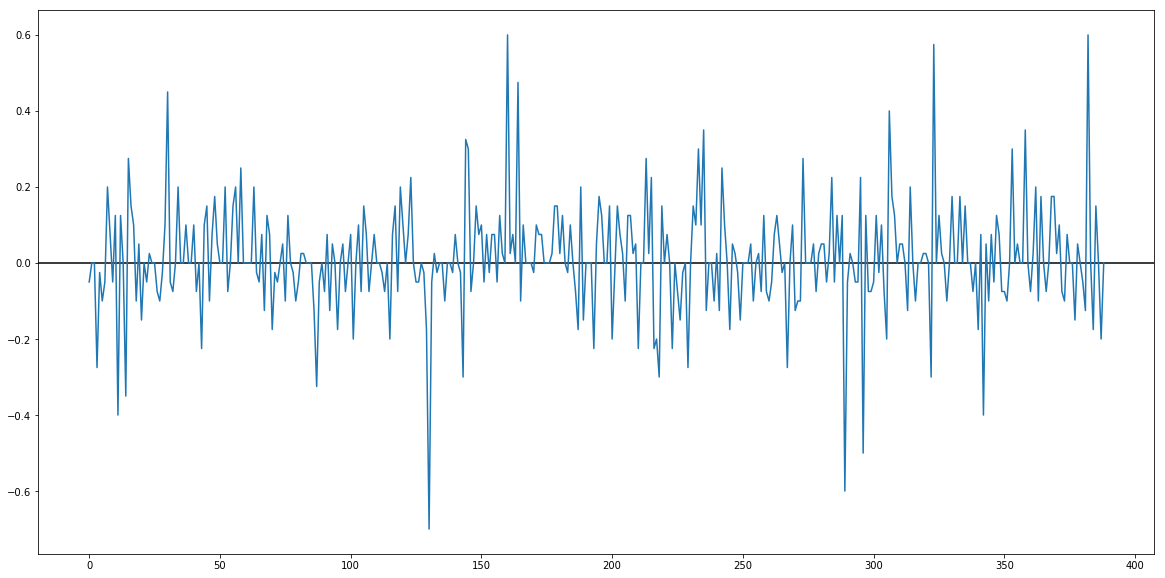

In [12]:
plt.rcParams["figure.figsize"] = [20.0,10.0]
plt.axhline(y=0, color='k')
plt.plot(ytest)
#plt.plot(regr.predict(Xtest))

In [13]:
1-regr.score(Xtest,ytest)

NameError: name 'regr' is not defined

In [ ]:
raw_data.nlargest(10, 'Temp_1H')

In [ ]:
for i in range(0,100):
    print(str(regr.predict(Xtest)[i]) + " | " + str(ytest[i]))

In [ ]:
np.array(([0], [1], [2], [3]), dtype=float)

In [ ]:
NN.W1

In [ ]:
#raw_data.to_csv('compiled.csv')
Xtrain

In [ ]:
np.dot(Xtrain,np.diag([2,1,1,1]))

In [ ]:
#Xmin = np.min(Xtrain,axis=0)
#Xtst = Xtrain-Xmin
#Xmax = np.max(Xtrain-Xmin,axis=0)
Xtst = np.dot(Xtrain-np.min(Xtrain,axis=0),np.diag(1/np.max(Xtrain-np.min(Xtrain,axis=0),axis=0)))
#Xtst,np.min(Xtst,axis=0),np.max(Xtst,axis=0),Xmin,Xmax
Xtst

In [ ]:
np.dot(Xtst,np.diag(Xmax))+Xmin

In [ ]:
np.dot(scale(Xtrain,Xmin,Xmax),syn0)

In [ ]:
def scale(X,Xmin,Xmax):
    return np.dot(X-Xmin,np.diag(1/Xmax))

In [ ]:
def unscale(X,Xmin,Xmax):
    return np.dot(X,np.diag(Xmax))+Xmin

In [ ]:
Xmin,Xmax = xMinMax(Xtrain)
Xtst = scale(Xtrain,Xmin,Xmax)
Xtrain,Xtst,unscale(Xtst,Xmin,Xmax)